In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

In [3]:
torch.cuda.is_available()

True

In [5]:
class MyProblem():
    def __init__(self):
        super().__init__()
        self.F = [0]*3
        self.G = [0]*10
        
        self.f_capital = 0
        self.v_mbp= 0
        self.v_fd = 0
        
    def evaluate(self, x): 
        #x:variable(numpy array), out:output(dictionary). 
        #out["F"]: numpy array with n_obj length, objective values are written here.
        #out["G"]: numpy array with n_constr length, constraints values are written here. 
        
        self.f_capital = 4.72 - 0.5*x[3] - 0.19*x[1]*x[2]
        self.v_mbp = 10.58 - 0.674*x[0]*x[1] - 0.67275*x[1]
        self.v_fd = 16.45 - 0.489*x[2]*x[6] - 0.843*x[4]*x[5]
        
        self.F[0] = 1.98 + 4.9*x[0] + 6.67*x[1] + 6.98*x[2] + 4.01*x[3] + 1.78*x[4] + 0.000001*x[5] + 2.73*x[6]
        self.F[1] = self.f_capital
        self.F[2] = 0.5*(self.v_mbp + self.v_fd)
        
        #constraints: g must be zero or negative
        self.G[0] = 1.16 - 0.3717*x[1]*x[3] - 0.0092928*x[2] -1 
        self.G[1] = 0.261 - 0.0159*x[0]*x[1] - 0.06486*x[0] - 0.019*x[1]*x[6] + 0.0144*x[2]*x[4] \
            + 0.0154464*x[5] - 0.32
        self.G[2] = 0.214 + 0.00817*x[4] - 0.045195*x[0] - 0.0135168*x[0] \
            + 0.03099*x[1]*x[5] - 0.018*x[1]*x[6] + 0.007176*x[2] \
            + 0.023232*x[2] - 0.00364*x[4]*x[5] - 0.018*x[1]**2 - 0.32
        self.G[3] = 0.74 - 0.61*x[1] - 0.031296*x[2] - 0.031872*x[6] + 0.227*x[1]**2 - 0.32
        self.G[4] = 28.98 + 3.818*x[2] - 4.2*x[0]*x[1] + 1.27296*x[5] - 2.68065*x[6] - 32
        self.G[5] = 33.86 + 2.95*x[2] - 5.057*x[0]*x[1] - 3.795*x[1] - 3.4431*x[6] + 1.45728 - 32
        self.G[6] = 46.36 - 9.9*x[1] - 4.4505*x[0] -32
        self.G[7] = self.f_capital - 4
        self.G[8] = self.v_mbp -9.9
        self.G[9] = self.v_fd -15.7
        
    def calc_loss(self, w):
        #w:weight
        return w[0]*self.F[0] + w[1]*self.F[1]*10 + w[2]*self.F[2] #だいたいオーダーをそろえるために1000倍した

## Adamによる最適化

In [6]:
lower = np.array([0.5, 0.45, 0.5, 0.5, 0.875, 0.4, 0.4]) #lower bound
upper = np.array([1.5, 1.35, 1.5, 1.5, 2.625, 1.2, 1.2]) #upper bound

In [7]:
losses = []
#weights = [0.1, 0.2, 0.3, 0.4, 0.5]
F_s = []
x_es = []

w = [0.0,0.0,1.0]

for n in range(101):
    #loss_temp_n = []
    
    for m in range(101):
        
        problem = MyProblem()
        x = torch.ones(7, requires_grad=True, device='cuda')
        optimizer = optim.Adam([x])
        loss_temp  =[n,m]
    
        for i in range(5000):
            optimizer.zero_grad()
            problem.evaluate(x)
            loss = problem.calc_loss(w)
            loss.backward()
            optimizer.step()
            loss_temp.append(loss)

            with torch.no_grad(): #不等式制約
                for j in range(len(lower)):
                    x[j].clamp_(lower[j],upper[j])
        
        F_temp = [problem.F[0].to('cpu').detach().numpy().copy(),
                  problem.F[1].to('cpu').detach().numpy().copy(),
                  problem.F[2].to('cpu').detach().numpy().copy()]

        F_s.append(F_temp)
        losses.append(loss_temp)
        x_es.append([n,m,x.to('cpu').detach().numpy()])
        
        print(w,x)
        
        if w[2]>0:
            w[0] = w[0] + 0.1
            w[2] = 1 - w[0] - w[1]
        else:
            break
        
    if (w[1]<1):
        w[0] = 0.0
        w[1] = w[1] + 0.1
        w[2] = 1 - w[0] - w[1]
    else:
        break

[0.0, 0.0, 1.0] tensor([1.5000, 1.3500, 1.5000, 1.0000, 2.6250, 1.2000, 1.2000],
       device='cuda:0', requires_grad=True)
[0.1, 0.0, 0.9] tensor([0.5000, 0.4500, 0.5000, 0.5000, 2.6250, 1.2000, 0.4000],
       device='cuda:0', requires_grad=True)
[0.2, 0.0, 0.8] tensor([0.5000, 0.4500, 0.5000, 0.5000, 2.6250, 1.2000, 0.4000],
       device='cuda:0', requires_grad=True)
[0.30000000000000004, 0.0, 0.7] tensor([0.5000, 0.4500, 0.5000, 0.5000, 0.8750, 1.2000, 0.4000],
       device='cuda:0', requires_grad=True)
[0.4, 0.0, 0.6] tensor([0.5000, 0.4500, 0.5000, 0.5000, 0.8750, 1.2000, 0.4000],
       device='cuda:0', requires_grad=True)
[0.5, 0.0, 0.5] tensor([0.5000, 0.4500, 0.5000, 0.5000, 0.8750, 1.2000, 0.4000],
       device='cuda:0', requires_grad=True)
[0.6, 0.0, 0.4] tensor([0.5000, 0.4500, 0.5000, 0.5000, 0.8750, 1.2000, 0.4000],
       device='cuda:0', requires_grad=True)
[0.7, 0.0, 0.30000000000000004] tensor([0.5000, 0.4500, 0.5000, 0.5000, 0.8750, 1.2000, 0.4000],
       devic

KeyboardInterrupt: 

In [10]:
Fs_np = np.array(F_s)

In [11]:
Fs_np.shape

(161, 3)

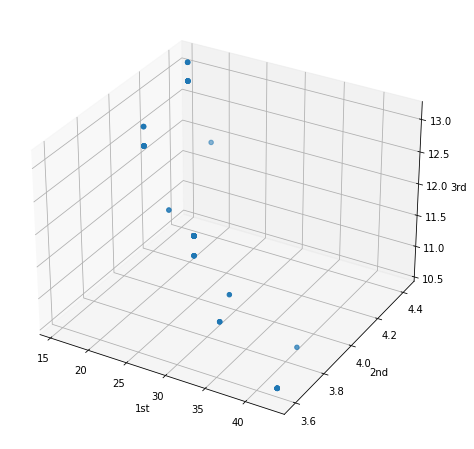

In [12]:
fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(projection='3d')
ax.scatter(Fs_np[:,0], Fs_np[:,1], Fs_np[:,2])
ax.set_xlabel("1st")
ax.set_ylabel("2nd")
ax.set_zlabel("3rd")
fig.show()

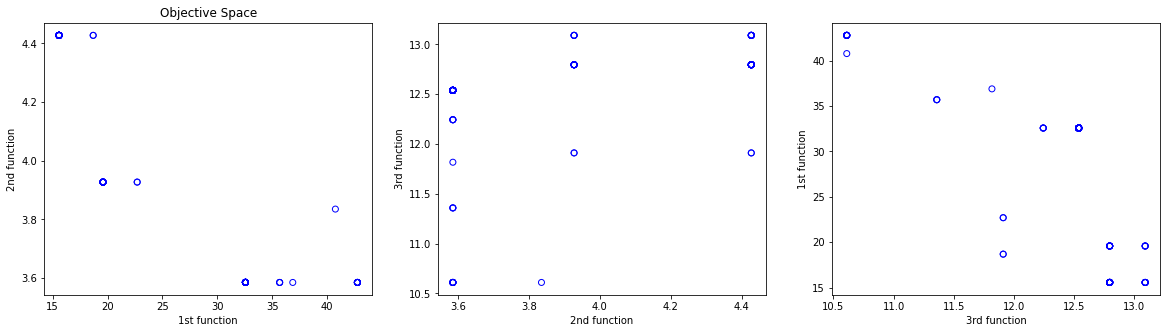

In [78]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(Fs_np[:, 0], Fs_np[:, 1], facecolors='none', edgecolors='blue')
ax1.set_xlabel("1st function")
ax1.set_ylabel("2nd function")

ax2.scatter(Fs_np[:, 1], Fs_np[:, 2], facecolors='none', edgecolors='blue')
ax2.set_xlabel("2nd function")
ax2.set_ylabel("3rd function")

ax3.scatter(Fs_np[:, 2], Fs_np[:, 0], facecolors='none', edgecolors='blue')
ax3.set_xlabel("3rd function")
ax3.set_ylabel("1st function")

ax1.set_title("Objective Space")
fig.show()

In [72]:
x_list = x_es[0][2]
for i in range(1,len(x_es)):
    x_list = np.vstack([x_list,x_es[i][2]])
x_list.shape

(161, 7)

In [74]:
df = pd.DataFrame(x_list)
df.columns=["x_0","x_1","x_2","x_3","x_4","x_5","x_6"]
df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6
0,1.5,1.35,1.5,1.0,2.625,1.2,1.2
1,0.5,0.45,0.5,0.5,2.625,1.2,0.4
2,0.5,0.45,0.5,0.5,2.625,1.2,0.4
3,0.5,0.45,0.5,0.5,0.875,1.2,0.4
4,0.5,0.45,0.5,0.5,0.875,1.2,0.4
...,...,...,...,...,...,...,...
156,0.5,1.35,1.5,1.5,0.875,0.4,0.4
157,0.5,1.35,1.5,1.5,0.875,0.4,0.4
158,0.5,1.35,1.5,1.5,0.875,0.4,0.4
159,0.5,1.35,1.5,1.5,0.875,0.4,0.4


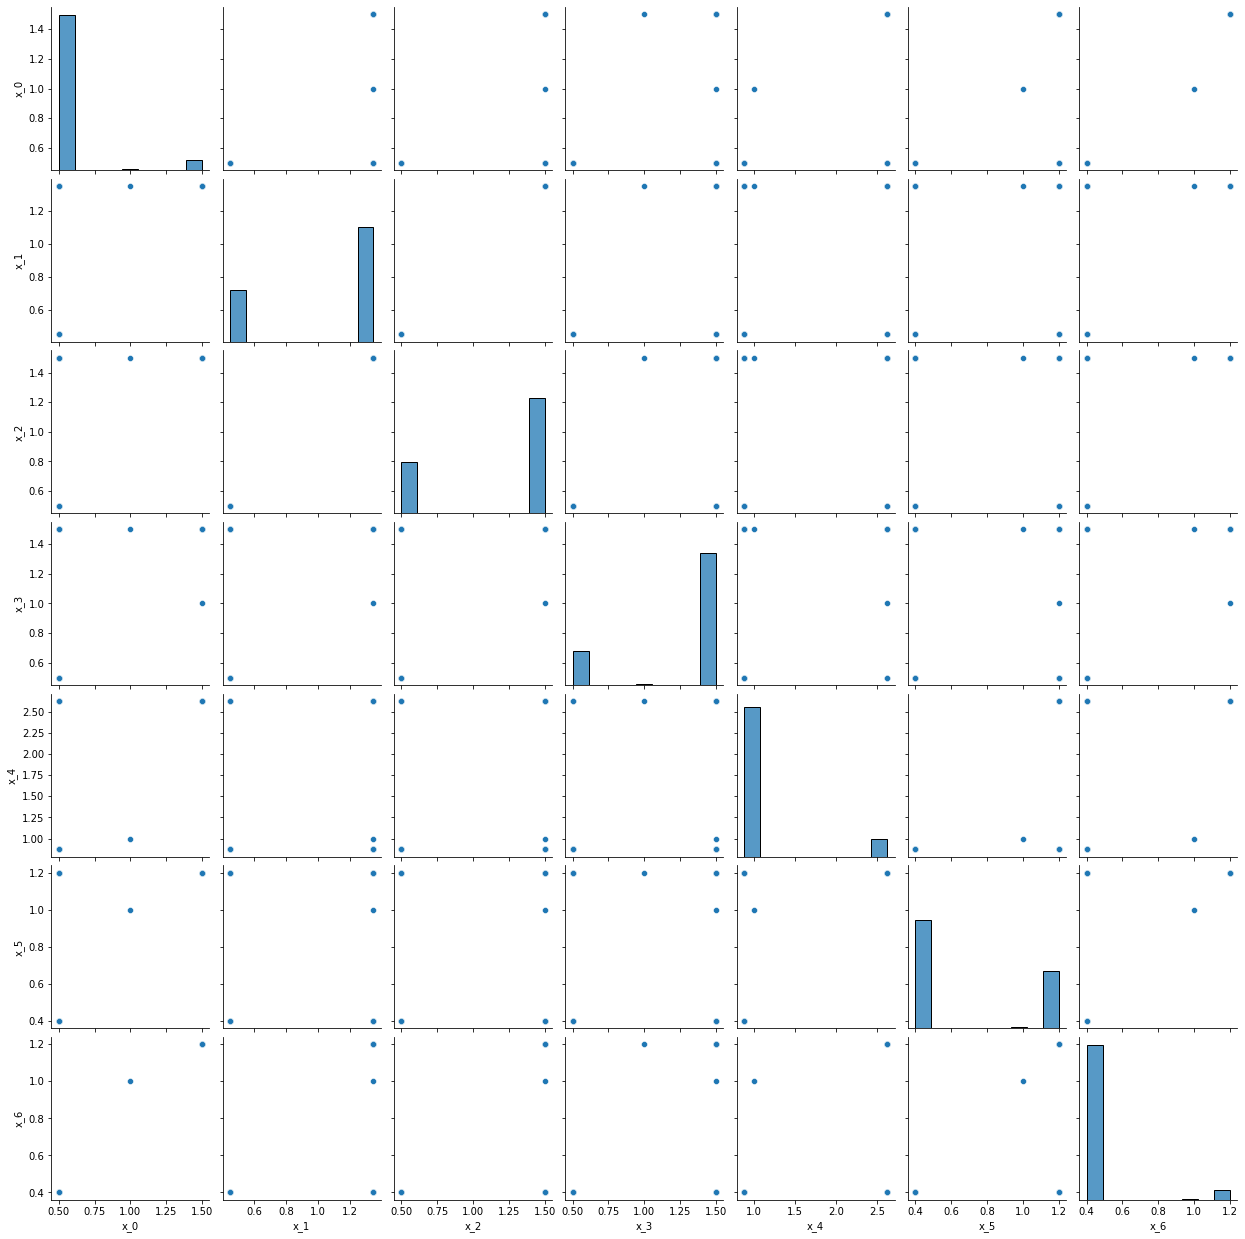

In [75]:
fig = sns.pairplot(df)
fig.savefig("08_pairplot")